# DIGNAD Parameter Grid Creation from Flood Simulations

This notebook creates a correlated parameter grid for DIGNAD pre-computation using the four key parameters from flood simulations:
- **dY_T**: Tradable output loss
- **dY_N**: Non-tradable output loss  
- **dK_priv**: Private capital loss
- **dK_pub**: Public capital loss

In [9]:
# Import live code changes in
%load_ext autoreload
%autoreload 

from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator

# Import the sampling functions
from sovereign.dignad_sampling_simplified import (
    create_comprehensive_dignad_grid,
    analyze_parameter_correlations,
    visualize_parameter_grid
)

# Import the resilient pre-computation
from sovereign.dignad_precompute_resilient import precompute_dignad_surface

from sovereign.flood import build_basin_curves, BasinLossCurve, risk_data_future_shift, run_simulation, extract_sectoral_losses
from sovereign.macroeconomic import run_flood_sim_for_macro, prepare_DIGNAD, run_DIGNAD

# Set style for nice plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: Load Your Flood Simulation Results

Assuming you have run your flood simulations and have the four DataFrames with columns [dY_T, dY_N, dK_priv, dK_pub]

In [10]:
root = Path.cwd().parent # find project root
THA_calibration_path = os.path.join(root, "inputs", "macro", "THA_2022_calibration_final.csv")
risk_basin_path = os.path.join(root, 'outputs', 'flood', 'risk', 'basins', 'risk_basins.csv')
copula_path = os.path.join(root, 'outputs', 'flood', 'dependence', 'copulas')
risk_data = pd.read_csv(risk_basin_path)
future_rp_shifts = pd.read_csv(os.path.join(root, 'outputs', 'flood', 'future', 'basin_rp_shifts.csv'))
# Drop first "unnamed column"
risk_data = risk_data.iloc[:, 1:]
# Add AEP column
risk_data['AEP'] = 1 / risk_data['RP']
# Add a column converting current prorection level into AEP
risk_data['Pr_L_AEP'] = np.where(risk_data['Pr_L'] == 0, 0, 1 / risk_data['Pr_L']) # using numpy where avoids zero division errors
risk_data.reset_index(drop=True, inplace=True)

In [11]:
#### 1. Flood simulation parameters
adaptation_aep = 0.01 # 100-year flood protection
n_years = 100000 # number of years to simulate
Thai_GDP = 496e9 # 2022 numbers in USD
future_hydro = 'jules-w2'
future_epoch = 2070
future_scenario = 'ssp585'
future_stat = 'q95'
# National GVA figures from DOSE
agr_GVA = 42880325598
man_GVA = 162659433017
ser_GVA = 316647741231
# Disaggregate output losses
TRADABLE_SHARES = {
    "Agriculture": 1.0,
    "Manufacturing": 0.7,
    "Service": 0.5,
}
#### 2. Macroeconomic model parameters
sim_start_year = 2022
nat_disaster_year = 2027
recovery_period = 3 # years
adaptation_cost = 21.97 # billion
reconstruction_efficiency = 0 # non-adjustable parameter
public_debt_premium = 0 # non-adjustable parameter
gdp_avg_years = 5 # we are intereseted in calculating average GDP impact over this period

In [12]:
# Adjust future risk data
future_risk_data = risk_data_future_shift(risk_data, future_rp_shifts, future_hydro, future_scenario, future_epoch, future_stat, degrade_protection=True)
# Build basin loss probability curves
baseline_curves: dict[int, BasinLossCurve] = build_basin_curves(risk_data)
future_curves: dict[int, BasinLossCurve] = build_basin_curves(future_risk_data)
# Load copula data
copula_random_numbers = pd.read_parquet(os.path.join(copula_path, "copula_random_numbers.gzip"))

In [13]:
# Run your flood simulations (or load saved results)
# Each should return a DataFrame with columns: [dY_T, dY_N, dK_priv, dK_pub]

baseline_current_df, baseline_adapted_df = run_flood_sim_for_macro(
    baseline_curves, adaptation_aep, n_years, copula_random_numbers,
    agr_GVA, man_GVA, ser_GVA, TRADABLE_SHARES, Thai_GDP
)

future_current_df, future_adapted_df = run_flood_sim_for_macro(
    future_curves, adaptation_aep, n_years, copula_random_numbers,
    agr_GVA, man_GVA, ser_GVA, TRADABLE_SHARES, Thai_GDP
)

print(f"Baseline current shape: {baseline_current_df.shape}")
print(f"Columns: {baseline_current_df.columns.tolist()}")
print("\nSample data:")
print(baseline_current_df.head())

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [13:06<00:00, 127.21it/s]

Baseline current shape: (100000, 5)
Columns: ['year_index', 'dY_T', 'dY_N', 'dK_priv', 'dK_pub']

Sample data:
   year_index      dY_T      dY_N   dK_priv    dK_pub
0           0  0.021815  0.020933  0.073071  0.027589
1           1  0.000302  0.000066  0.000427  0.000402
2           2  0.000000  0.000000  0.000000  0.000000
3           3  0.000818  0.000676  0.001666  0.001195
4           4  0.000023  0.000009  0.000035  0.000039


## Step 2: Combine All Scenarios and Analyze Correlations

In [14]:
# Combine all scenarios into one DataFrame
flood_combined = pd.concat([baseline_current_df, future_current_df], ignore_index=True)

print(f"\nTotal combined simulations: {len(flood_combined)}")
print("\nParameter ranges across all scenarios:")
print(flood_combined[['dY_T', 'dY_N', 'dK_priv', 'dK_pub']].describe().round(3))


Total combined simulations: 200000

Parameter ranges across all scenarios:
             dY_T        dY_N     dK_priv      dK_pub
count  200000.000  200000.000  200000.000  200000.000
mean        0.015       0.016       0.031       0.012
std         0.037       0.043       0.072       0.025
min         0.000       0.000       0.000       0.000
25%         0.000       0.000       0.000       0.000
50%         0.001       0.001       0.002       0.001
75%         0.008       0.005       0.014       0.008
max         0.249       0.282       0.462       0.168


In [15]:
# Analyze correlations - this is crucial!
corr_matrix = analyze_parameter_correlations(flood_combined, plot=False)


Key Parameter Correlations:
dY_T ↔ dY_N: +0.997
dY_T ↔ dK_priv: +0.984
dY_T ↔ dK_pub: +0.977
dY_N ↔ dK_priv: +0.972
dY_N ↔ dK_pub: +0.962
dK_priv ↔ dK_pub: +0.998


## Step 3: Create the DIGNAD Parameter Grid

This creates a representative grid that preserves the correlations from your flood simulations

In [17]:
# Choose number of DIGNAD simulations to pre-compute
# Rule of thumb: 500-1000 for good coverage of 4D space
n_dignad_simulations = 1000  # This will take ~16.7 hours

# Create the parameter grid
param_grid = create_comprehensive_dignad_grid(
    flood_combined,
    n_samples=n_dignad_simulations,
    method='combined',  # Uses multiple sampling methods
)


 Creating parameter grid with 1000 points...

Creating DIGNAD parameter grid using 'combined' method...
Target samples: 1000

Final parameter grid:
  Grid size: 866 unique combinations
  Parameter ranges:
    dY_T: [0.000, 0.249]
    dY_N: [0.000, 0.282]
    dK_priv: [0.000, 0.462]
    dK_pub: [0.000, 0.168]


In [21]:
param_grid.to_csv("param_grid_1000.csv")

In [19]:
# Examine the parameter grid
print("Parameter grid structure:")
print(param_grid.columns.tolist())
print(f"\nGrid size: {len(param_grid)} unique parameter combinations")
print("\nFirst few entries:")
print(param_grid[['tradable_impact', 'nontradable_impact', 
                  'private_impact', 'public_impact']].head(10).round(3))

Parameter grid structure:
['tradable_impact', 'nontradable_impact', 'private_impact', 'public_impact', 'grid_method', 'grid_index', 'share_tradable', 'reconstruction_efficiency', 'public_debt_premium']

Grid size: 866 unique parameter combinations

First few entries:
   tradable_impact  nontradable_impact  private_impact  public_impact
0            0.003               0.002           0.011          0.006
1            0.118               0.143           0.192          0.063
2            0.198               0.234           0.367          0.125
3            0.031               0.028           0.097          0.037
4            0.000               0.000           0.000          0.000
5            0.069               0.070           0.182          0.063
6            0.127               0.139           0.288          0.104
7            0.015               0.013           0.047          0.016
8            0.217               0.253           0.409          0.142
9            0.050              

## Step 4: Validate Grid Coverage

Check how well the grid represents the full parameter space


Grid Coverage Statistics:
mean_distance: 0.0008
median_distance: 0.0002
max_distance: 0.0260
std_distance: 0.0014
p95_distance: 0.0040
p99_distance: 0.0067
pct_well_covered: 100.0%


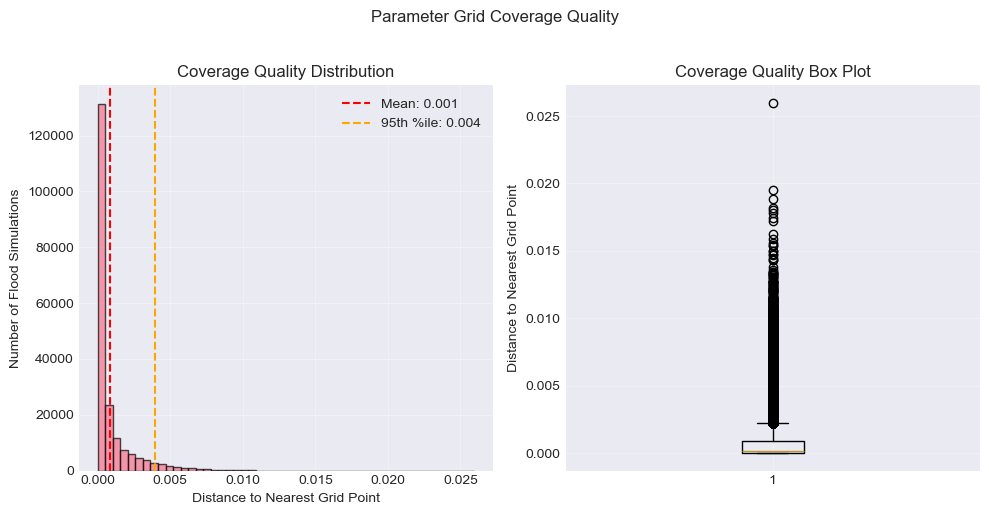


✓ Excellent coverage: 95% of flood simulations are well-represented


In [20]:
from sovereign.dignad_sampling_simplified import calculate_grid_coverage

# Calculate coverage statistics
coverage_stats = calculate_grid_coverage(
    param_grid, 
    flood_combined,
    max_distance_threshold=0.02  # Define "good" coverage
)

# Interpretation
if coverage_stats['p95_distance'] < 1.0:
    print("\n✓ Excellent coverage: 95% of flood simulations are well-represented")
elif coverage_stats['p95_distance'] < 2.0:
    print("\n✓ Good coverage: Most flood simulations are reasonably represented")
else:
    print("\n⚠️ Consider increasing n_samples for better coverage")

## Step 5: Run DIGNAD Pre-computation with Checkpointing

This is the computationally expensive part, but with checkpointing you can safely interrupt and resume

In [30]:
# Calibrate DIGNAD (baseline = no adaptation)
prepare_DIGNAD(THA_calibration_path, adaptation_cost=adaptation_cost)

In [31]:
# Run pre-compuataion
results = []
failure_index = []
for row in tqdm(param_grid.itertuples(index=False), total=len(param_grid), desc="Running DIGNAD precomputation"):
    # Extract shock paramaters
    index = row.grid_index
    tradable_impact = row.tradable_impact
    nontradable_impact = row.nontradable_impact
    private_impact = row.private_impact
    public_impact = row.public_impact
    share_tradable = row.share_tradable
    reconstruction_efficiency = row.reconstruction_efficiency
    public_debt_premium = row.public_debt_premium

    # If shocks are 0 don't run DIGNAD
    if tradable_impact == 0 and nontradable_impact == 0 and private_impact == 0 and public_impact == 0:
        results.append({
            "index": index,
            "gdp_avg": 0
        })
        continue

    # Run DIGNAD
    gdp_impact, years = run_DIGNAD(sim_start_year, nat_disaster_year, recovery_period, tradable_impact, nontradable_impact,
                                    reconstruction_efficiency, public_debt_premium, public_impact, private_impact, share_tradable)

    if gdp_impact is None:
        # Means MatLab failed to execute
        failure_index.append(index)
        gdp_avg = None
    else:
        t_shock = nat_disaster_year-sim_start_year
        gdp_avg = np.mean(gdp_impact[t_shock : t_shock + gdp_avg_years])

    results.append({
        "index": index,
        "gdp_avg": gdp_avg
    })
results_df = pd.DataFrame(results)

Running DIGNAD precomputation:  70%|██████████████████████████████▉             | 608/866 [12:03:10<4:47:10, 66.79s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  71%|███████████████████████████████▍            | 619/866 [12:16:02<4:37:55, 67.51s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  72%|███████████████████████████████▌            | 621/866 [12:18:07<4:24:14, 64.71s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  72%|███████████████████████████████▋            | 624/866 [12:21:42<4:35:50, 68.39s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  72%|███████████████████████████████▊            | 626/866 [12:23:54<4:28:36, 67.15s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  75%|████████████████████████████████▉           | 648/866 [12:49:00<3:55:04, 64.70s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  75%|█████████████████████████████████           | 650/866 [12:51:14<3:55:29, 65.41s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  76%|█████████████████████████████████▌          | 661/866 [13:03:49<3:43:07, 65.30s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  78%|██████████████████████████████████▏         | 674/866 [13:18:37<3:27:48, 64.94s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  78%|██████████████████████████████████▎         | 675/866 [13:19:36<3:21:33, 63.32s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  79%|██████████████████████████████████▌         | 680/866 [13:25:16<3:24:23, 65.93s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  79%|██████████████████████████████████▌         | 681/866 [13:26:23<3:24:16, 66.25s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  79%|██████████████████████████████████▋         | 682/866 [13:27:39<3:32:07, 69.17s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  79%|██████████████████████████████████▉         | 688/866 [13:34:24<3:13:40, 65.28s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  80%|███████████████████████████████████▎        | 695/866 [13:42:14<3:05:29, 65.09s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  85%|█████████████████████████████████████▍      | 736/866 [14:27:24<2:18:01, 63.70s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  85%|█████████████████████████████████████▌      | 740/866 [14:31:44<2:11:52, 62.80s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  87%|██████████████████████████████████████      | 750/866 [14:42:17<1:59:35, 61.86s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  89%|███████████████████████████████████████▎    | 774/866 [15:08:13<1:35:21, 62.19s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  93%|████████████████████████████████████████▊   | 804/866 [15:40:53<1:03:06, 61.07s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  94%|███████████████████████████████████████████▎  | 815/866 [15:53:17<55:32, 65.35s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  95%|███████████████████████████████████████████▋  | 823/866 [16:02:03<46:35, 65.00s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation:  97%|████████████████████████████████████████████▊ | 843/866 [16:23:45<24:22, 63.60s/it]

MATLAB script not executed succesfully


Running DIGNAD precomputation: 100%|██████████████████████████████████████████████| 866/866 [19:09:30<00:00, 79.64s/it]


In [32]:
# Combine for interpolation run
precomputed_results = param_grid.merge(results_df, left_on="grid_index", right_on="index")
precomputed_results = precomputed_results[precomputed_results['gdp_avg'].notna()] # remove NaN / failed

# Rename columns to match simulation outputs
precomputed_results_r = precomputed_results.copy()
precomputed_results_r.rename(columns={
        'tradable_impact': 'dY_T',
        'nontradable_impact': 'dY_N', 
        'private_impact': 'dK_priv',
        'public_impact': 'dK_pub'
    }, inplace=True)

In [33]:
# Save to CSV
precomputed_results_r.to_csv("F:\Projects\sovereign-risk\outputs\macro\DIGNAD_presim_n1000_adapt.csv")

In [27]:
# Create interpolators
X = precomputed_results_r[['dY_T', 'dY_N', 'dK_priv', 'dK_pub']].values
y = precomputed_results_r['gdp_avg'].values

linear_interp = LinearNDInterpolator(X, y)
nearest_interp = NearestNDInterpolator(X, y)

# Interpolation function for monte carlo analysis
def interpolate_gdp(params):
    gdp = linear_interp(params)
    if np.isnan(gdp): # if outside convex hull
        gdp = nearest_interp(params)
    if np.all(params == 0): # no disaster
        gdp = 0.0
    return gdp

#### Compare interpolation and actual DIGNAD run

In [28]:
# Just use a subset of the actual simulations
subset = baseline_current_df[200:220]
real_GDP = []
interp_GDP = []
for row in tqdm(subset.itertuples(index=False), total=len(subset), desc="Running Interpolation Evaluation"):
    # Extract shock parameters
    year = row.year_index
    dY_T = row.dY_T
    dY_N = row.dY_N
    dK_priv = row.dK_priv
    dK_pub = row.dK_pub

    # If shocks are 0 don't run DIGNAD or interpolation
    if dY_T == 0 and dY_N == 0 and dK_priv == 0 and dK_pub == 0:
        real_GDP.append({
            "year_index": year,
            "gdp": 0
        })
        interp_GDP.append({
            "year_index": year,
            "gdp": 0
        })
        continue

    # Run DIGNAD
    gdp_impact, years = run_DIGNAD(sim_start_year, nat_disaster_year, recovery_period, dY_T, dY_N, reconstruction_efficiency,#
                                    public_debt_premium, dK_pub, dK_priv, 0.5)

    if gdp_impact is None:
        # Means Matlab failed to execute
        real_GDP.append({
            "year_index": year,
            "gdp": np.nan
        })
    else:
        # Compute average GDP impact after shock
        t_shock = nat_disaster_year - sim_start_year
        gdp_avg = np.mean(gdp_impact[t_shock : t_shock + gdp_avg_years])
    real_GDP.append({
        "year_index": year,
        "gdp": gdp_avg
    })

    # Run interpolation
    params = [dY_T, dY_N, dK_priv, dK_pub]
    gdp = interpolate_gdp(params)
    interp_GDP.append({
        "year_index": year,
        "gdp": gdp
    })

Running Interpolation Evaluation: 100%|████████████████████████████████████████████████| 20/20 [09:54<00:00, 29.75s/it]


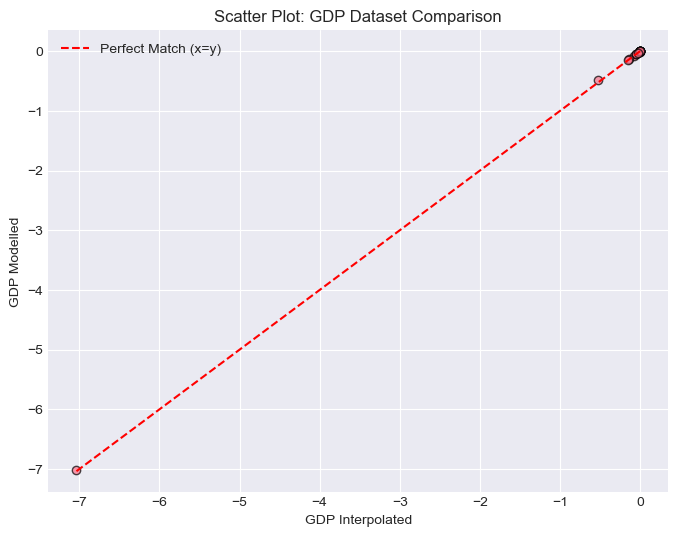

{'mean_difference': -0.002515902849730748, 'mean_absolute_difference': 0.002529105223613497, 'max_difference': 7.0777893275073e-05, 'min_difference': -0.03746502878078961}


In [29]:
# --- Extract GDP values as floats (handling arrays and zeros) ---
def extract_gdp(d):
    g = d['gdp']
    if isinstance(g, np.ndarray):
        return float(g[0])
    return float(g)

gdp_int = np.array([extract_gdp(d) for d in interp_GDP])
gdp_mod = np.array([extract_gdp(d) for d in real_GDP])

years = np.array([d['year_index'] for d in interp_GDP])

# --- Scatter Plot ---
plt.figure(figsize=(8,6))
plt.scatter(gdp_int, gdp_mod, alpha=0.7, edgecolor='k')
plt.plot([gdp_int.min(), gdp_mod.max()],
         [gdp_int.min(), gdp_mod.max()],
         'r--', label='Perfect Match (x=y)')
plt.xlabel("GDP Interpolated")
plt.ylabel("GDP Modelled")
plt.title("Scatter Plot: GDP Dataset Comparison")
plt.legend()
plt.grid(True)
plt.show()

# --- Difference calculations ---
diff = gdp_int - gdp_mod
abs_diff = np.abs(diff)

stats = {
    "mean_difference": diff.mean(),
    "mean_absolute_difference": abs_diff.mean(),
    "max_difference": diff.max(),
    "min_difference": diff.min()
}

print(stats)